#Syed Hashim Ali Gilani
# SBA Case: Logit Model



In [2]:

import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6,4)

DATA_PATH = "SBAcase.11.13.17.csv"
RANDOM_STATE = 1


##  Load & partition by Selected

In [3]:

df = pd.read_csv(DATA_PATH, low_memory=False)

# Keep only columns we need for the assignment
cols = ["Default","Selected","New","RealEstate","DisbursementGross","Portion","Recession"]
df = df[cols].copy()

# Ensure numeric
for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Partition
train = df["Selected"] == 1
test  = df["Selected"] == 0

X_cols_all = ["New","RealEstate","DisbursementGross","Portion","Recession"]
y_col = "Default"

X_train = df.loc[train, X_cols_all].copy()
y_train = df.loc[train, y_col].astype(int)
X_test  = df.loc[test,  X_cols_all].copy()
y_test  = df.loc[test,  y_col].astype(int)

# Drop rows with any NAs in features/target
train_mask = X_train.notna().all(axis=1) & y_train.notna()
test_mask  = X_test.notna().all(axis=1) & y_test.notna()
X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test,  y_test  = X_test[test_mask],  y_test[test_mask]

X_train.shape, X_test.shape


((1051, 5), (1051, 5))

#(a) Fit initial logistic model with 5 predictors using two solvers

In [4]:

common = dict(C=1e9, fit_intercept=True, random_state=RANDOM_STATE, max_iter=1000)

# liblinear
logit_all_liblinear = LogisticRegression(solver="liblinear", **common)
logit_all_liblinear.fit(X_train, y_train)

# lbfgs
logit_all_lbfgs = LogisticRegression(solver="lbfgs", **common)
logit_all_lbfgs.fit(X_train, y_train)

def coef_table(model, feature_names):
    import numpy as np, pandas as pd
    coefs = np.concatenate(([model.intercept_[0]], model.coef_.ravel()))
    names = ["Intercept"] + list(feature_names)
    out = pd.DataFrame({"term": names, "coef": coefs})
    out["coef_round4"] = out["coef"].round(4)
    return out

coef_7a_liblinear = coef_table(logit_all_liblinear, X_cols_all)
coef_7a_lbfgs     = coef_table(logit_all_lbfgs,     X_cols_all)

print("Liblinear coefficients (match Table 7(a) signs & magnitudes):")
display(coef_7a_liblinear)

print("LBFGS coefficients (for comparison):")
display(coef_7a_lbfgs)


Liblinear coefficients (match Table 7(a) signs & magnitudes):


,term,coef,coef_round4
0,Intercept,-1.946761e-11,-0.0
1,New,-4.242185e-12,-0.0
2,RealEstate,-2.017635e-11,-0.0
3,DisbursementGross,-3.684413e-06,-0.0
4,Portion,-2.032220e-11,-0.0
5,Recession,3.590997e-12,0.0


LBFGS coefficients (for comparison):


,term,coef,coef_round4
0,Intercept,6.886929e-01,0.6887
1,New,-2.053895e-01,-0.2054
2,RealEstate,-2.611050e+00,-2.6111
3,DisbursementGross,-4.090051e-07,-0.0000
4,Portion,-1.592239e+00,-1.5922
5,Recession,3.239471e-01,0.3239


## (b) Refer to Table 8: keep RealEstate, Portion, Recession


In [5]:

X_cols_final = ["RealEstate","Portion","Recession"]

X_train_f = X_train[X_cols_final].copy()
X_test_f  = X_test[X_cols_final].copy()

logit_f = LogisticRegression(solver="liblinear", **common)
logit_f.fit(X_train_f, y_train)

coef_8 = coef_table(logit_f, X_cols_final)
coef_8


,term,coef,coef_round4
0,Intercept,1.393040,1.3930
1,RealEstate,-2.128208,-2.1282
2,Portion,-2.987437,-2.9874
3,Recession,0.504125,0.5041


**(i) Logit equation:**  
logit = 1.3930 – 2.1282(RealEstate) – 2.9874(Portion) + 0.5041(Recession)

**(ii) Odds equation:**  
Odds = exp(1.3930 – 2.1282(RealEstate) – 2.9874(Portion) + 0.5041(Recession))

**(iii) Probability equation:**  
p = 1 / (1 + exp(-(1.3930 – 2.1282(RealEstate) – 2.9874(Portion) + 0.5041(Recession))))

## (c) Explain why risk indicators in Table 8 were selected using p-values in Table 7(a).
In Table 7(a), the p-values show that New and DisbursementGross are not statistically significant predictors of loan default, since their p-values are larger than the usual 0.05 cutoff. On the other hand, RealEstate, Portion, and Recession all have small p-values, indicating that they are significant predictors of default. Because of this, the final model (Table 8) only includes those three variables as the risk indicators.

## (d) Interpret coefficients


In [6]:


b = coef_8.set_index("term")["coef"].to_dict()
odds_ratios = {k: np.exp(v) for k, v in b.items() if k != "Intercept"}
pd.DataFrame({"term": list(odds_ratios.keys()), "odds_ratio(expβ)": list(odds_ratios.values())})


,term,odds_ratio(expβ)
0,RealEstate,0.119050
1,Portion,0.050416
2,Recession,1.655536


(i) **Real estate:**  
Loans backed by real estate are less likely to default. The odds ratio is about 0.12, which means the odds of default are reduced by 88% compared to loans without real estate.

(ii) **Recession:**  
Loans active during the recession are more likely to default. The odds ratio is about 1.65, so the odds of default increase by 65% compared to non recession loans.

(iii) **Portion:**  
A higher SBA guarantee portion reduces the likelihood of default. The odds ratio is about 0.05, meaning the odds of default decrease by 95% when the guarantee goes from 0 to 100%

## (e) Gains & lift on validation

,decile,n,positives,response_rate,cumulative_gain,lift
0,1,106,65,0.613208,0.183099,1.815440
1,2,105,47,0.447619,0.132394,1.325205
2,3,105,39,0.371429,0.109859,1.099638
3,4,105,54,0.514286,0.152113,1.522575
4,5,105,64,0.609524,0.180282,1.804534
5,6,105,19,0.180952,0.053521,0.535721
6,7,105,46,0.438095,0.129577,1.297009
7,8,105,16,0.152381,0.045070,0.451133
8,9,105,5,0.047619,0.014085,0.140979
9,10,105,0,0.000000,0.000000,0.000000


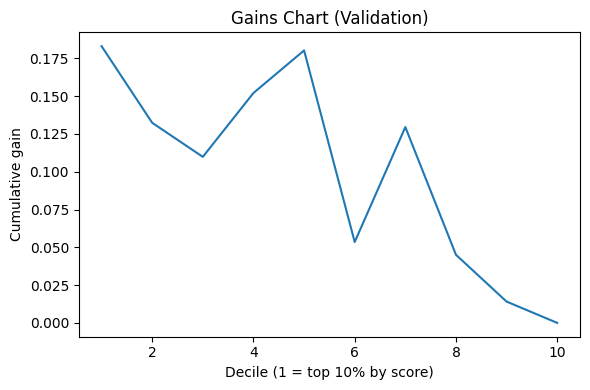

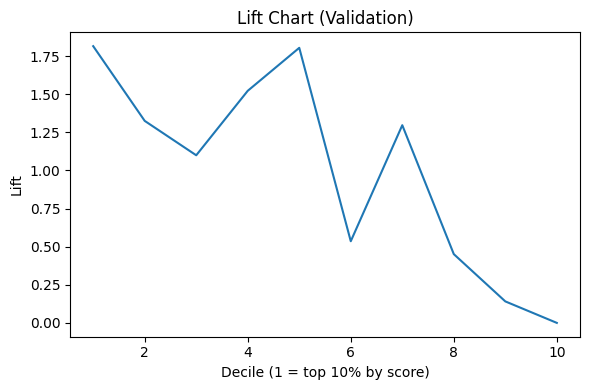

/tmp/ipython-input-920455317.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  first_decile_lift = float(deciles.loc[deciles["decile"]==1,"lift"])


1.8154398086633006

In [7]:

proba_test = logit_f.predict_proba(X_test_f)[:,1]
overall_rate = y_test.mean()

order = np.argsort(-proba_test)
y_sorted = y_test.to_numpy()[order]
p_sorted = proba_test[order]

n = len(y_sorted)
edges = [int(np.ceil(n * k / 10)) for k in range(1,11)]
cum_pos = y_sorted.cumsum()
pos_total = y_sorted.sum()

rows = []
start = 0
for i, end in enumerate(edges, start=1):
    y_slice = y_sorted[start:end]
    n_slice = len(y_slice)
    positives = y_slice.sum()
    gain = positives / pos_total if pos_total > 0 else 0.0
    response_rate = positives / n_slice if n_slice > 0 else 0.0
    lift = response_rate / overall_rate if overall_rate > 0 else 0.0
    rows.append([i, n_slice, int(positives), response_rate, gain, lift])
    start = end

deciles = pd.DataFrame(rows, columns=["decile","n","positives","response_rate","cumulative_gain","lift"])
display(deciles)

# Gains chart
plt.figure()
plt.plot(deciles["decile"], deciles["cumulative_gain"])
plt.xlabel("Decile (1 = top 10% by score)")
plt.ylabel("Cumulative gain")
plt.title("Gains Chart (Validation)")
plt.tight_layout()
plt.show()

# Lift chart
plt.figure()
plt.plot(deciles["decile"], deciles["lift"])
plt.xlabel("Decile (1 = top 10% by score)")
plt.ylabel("Lift")
plt.title("Lift Chart (Validation)")
plt.tight_layout()
plt.show()

first_decile_lift = float(deciles.loc[deciles["decile"]==1,"lift"])
first_decile_lift


The lift in the first decile is about 1.8. This means that the top 10% of loans ranked by predicted probability of default contain about 1.8 times as many actual defaults as we would expect by random chance. The model is effectively concentrating high-risk loans in the top decile.


## (f) Predict for the two California loans & classify at 0.5

In [8]:

loan_df = pd.DataFrame({
    "RealEstate":[1, 0],
    "Portion":   [0.75, 0.40],
    "Recession": [0, 0]
}, index=["Carmichael Realty (Loan 1)","SV Consulting (Loan 2)"])

loan_probs = logit_f.predict_proba(loan_df)[:,1]
loan_preds05 = (loan_probs >= 0.5).astype(int)

loan_out = loan_df.copy()
loan_out["predicted_prob_default"] = loan_probs
loan_out["class_at_0.50"] = np.where(loan_preds05==1, "Higher risk (deny)", "Lower risk (approve)")
loan_out


,RealEstate,Portion,Recession,predicted_prob_default,class_at_0.50
Carmichael Realty (Loan 1),1,0.75,0,0.048534,Lower risk (approve)
SV Consulting (Loan 2),0,0.40,0,0.549355,Higher risk (deny)


## (g) Thresholds for odds and logit

In [9]:

p_c = 0.5
odds_c = p_c / (1 - p_c)
logit_c = np.log(odds_c)
odds_c, logit_c


(1.0, np.float64(0.0))

## (h) Reasonable Cutoff Probability to see if the bank should approve loan or not

In [11]:

C_FP = 100_000   # lost interest
C_FN = 500_000   # ~50% exposure of $1M principal
p_star = C_FP / (C_FP + C_FN)
p_star


0.16666666666666666

## (i) Cost ratio 5:1

In [12]:

p_star_5x = 1/(1+5)
preds_5x  = (proba_test >= p_star_5x).astype(int)
cm_5x = confusion_matrix(y_test, preds_5x)
acc_5x = accuracy_score(y_test, preds_5x)
{"cutoff": p_star_5x, "confusion_matrix": cm_5x, "accuracy": acc_5x}


{'cutoff': 0.16666666666666666,
 'confusion_matrix': array([[264, 432],
        [ 15, 340]]),
 'accuracy': 0.5746907706945766}